[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/porterjenkins/byu-cs474/blob/master/lab10_diffusion.ipynb)

# Denoising Diffusion Probabilistic Models (DDPM)

## Description

In this lab, we train an image generation model using diffusion. Diffusion is just one of several techniques to generate images, but it has recently surpassed the GAN as the state-of-the-art generation model.

The diffusion model is trained to remove noise from images, and once it is fully trained it can take random noise and fully "denoise" it into an image that looks reasonably like the training set.

## Objectives
- Implement forward process of diffusion
- Implement backward process of diffusion
- Generate images with the diffusion process
- Answer questions about diffusion

## Grading Criteria
- Scheduling (10%)
- Forward Diffusion (30%)
- Backward Diffusion (30%)
- Image Generation (20%)
- Answers to Questions (10%)

### Helpful Reading
- Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
- Improved Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2102.09672



In [1]:
from abc import abstractmethod
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, Resize, Lambda, ToTensor

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
# Hyperparameters
MAX_TIMESTEPS = 1000
image_size = 32
lr = .0001

We have given you a simpler version of the UNet used in "Improved Denoising Diffusion Probabilistic Models." Feel free to familiarize yourself with the model. It is similar to the UNet we made in the cancer detection lab, but has layers that incorporate the timestep embedding. The model is already fully implemented.

In [3]:
def zero_module(module):
    for p in module.parameters():
        p.detach().zero_()
    return module


def timestep_embedding(timesteps, dim, max_period=10000):
    half = dim // 2
    freqs = torch.exp(
        -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
    ).to(device=timesteps.device)
    args = timesteps[:, None].float() * freqs[None]
    embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
    if dim % 2:
        embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
    return embedding


# Note: this is an abstract method, do not implement `forward`
class TimestepBlock(nn.Module):
    @abstractmethod
    def forward(self, x, emb):
        """
        Apply the module to `x` given `emb` timestep embeddings.
        """


class TimestepEmbedSequential(nn.Sequential, TimestepBlock):
    def forward(self, x, emb):
        for layer in self:
            if isinstance(layer, TimestepBlock):
                x = layer(x, emb)
            else:
                x = layer(x)
        return x


class Upsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.conv = nn.Conv2d(channels, channels, 3, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        x = F.interpolate(x, scale_factor=2, mode="nearest")
        x = self.conv(x)
        return x


class Downsample(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.channels = channels
        self.op = nn.Conv2d(channels, channels, 3, stride=2, padding=1)

    def forward(self, x):
        assert x.shape[1] == self.channels
        return self.op(x)


class ResBlock(TimestepBlock):
    def __init__(
        self,
        channels,
        emb_channels,
        dropout,
        out_channels=None,
    ):
        super().__init__()
        self.channels = channels
        self.emb_channels = emb_channels
        self.dropout = dropout
        self.out_channels = out_channels or channels

        self.in_layers = nn.Sequential(
            nn.GroupNorm(32, channels),
            nn.SiLU(),
            nn.Conv2d(channels, self.out_channels, 3, padding=1)
        )
        self.emb_layers = nn.Sequential(
            nn.SiLU(),
            nn.Linear(emb_channels, self.out_channels)
        )
        self.out_layers = nn.Sequential(
            nn.GroupNorm(32, self.out_channels),
            nn.SiLU(),
            nn.Dropout(p=dropout),
            zero_module(nn.Conv2d(self.out_channels, self.out_channels, 3, padding=1)),
        )

        if self.out_channels == channels:
            self.skip_connection = nn.Identity()
        else:
            self.skip_connection = nn.Conv2d(channels, self.out_channels, kernel_size=1)

    def forward(self, x, emb):
        h = self.in_layers(x)
        emb_out = self.emb_layers(emb).type(h.dtype)
        while len(emb_out.shape) < len(h.shape):
            emb_out = emb_out[..., None]
        h = h + emb_out
        h = self.out_layers(h)
        return self.skip_connection(x) + h


class UNetModel(nn.Module):
    """
    The full UNet model with timestep embedding.

    :param in_channels: channels in the input Tensor.
    :param model_channels: base channel count for the model.
    :param out_channels: channels in the output Tensor.
    :param num_res_blocks: number of residual blocks per downsample.
    :param dropout: the dropout probability.
    :param channel_mult: channel multiplier for each level of the UNet.
    """

    def __init__(
        self,
        in_channels,
        hidden_channels,
        out_channels,
        num_res_blocks,
        dropout=0,
        channel_mult=(1, 2, 4, 8),
    ):
        super().__init__()
        self.in_channels = in_channels
        self.model_channels = hidden_channels
        self.out_channels = out_channels
        self.num_res_blocks = num_res_blocks
        self.dropout = dropout
        self.channel_mult = channel_mult

        time_embed_dim = hidden_channels * 4
        self.time_embed = nn.Sequential(
            nn.Linear(hidden_channels, time_embed_dim),
            nn.SiLU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        self.input_blocks = nn.ModuleList([
            TimestepEmbedSequential(nn.Conv2d(in_channels, hidden_channels, 3, padding=1))
        ])
        input_block_chans = [hidden_channels]
        ch = hidden_channels
        ds = 1
        for level, mult in enumerate(channel_mult):
            for _ in range(num_res_blocks):
                layers = [ResBlock(ch, time_embed_dim, dropout, out_channels=mult * hidden_channels)]
                ch = mult * hidden_channels
                self.input_blocks.append(TimestepEmbedSequential(*layers))
                input_block_chans.append(ch)
            if level != len(channel_mult) - 1:
                self.input_blocks.append(TimestepEmbedSequential(Downsample(ch)))
                input_block_chans.append(ch)
                ds *= 2

        self.middle_block = TimestepEmbedSequential(
            ResBlock(ch, time_embed_dim, dropout),
            ResBlock(ch, time_embed_dim, dropout),
        )

        self.output_blocks = nn.ModuleList([])
        for level, mult in list(enumerate(channel_mult))[::-1]:
            for i in range(num_res_blocks + 1):
                layers = [
                    ResBlock(
                        ch + input_block_chans.pop(),
                        time_embed_dim,
                        dropout,
                        out_channels=hidden_channels * mult,
                    )
                ]
                ch = hidden_channels * mult
                if level and i == num_res_blocks:
                    layers.append(Upsample(ch))
                    ds //= 2
                self.output_blocks.append(TimestepEmbedSequential(*layers))

        self.out = nn.Sequential(
            nn.GroupNorm(32, ch),
            nn.SiLU(),
            zero_module(nn.Conv2d(hidden_channels, out_channels, 3, padding=1))
        )

    def forward(self, x, timesteps):
        """
        Apply the model to an input batch.

        :param x: an [N x C x H x W] Tensor of inputs.
        :param timesteps: a 1-D batch of timesteps.
        :return: an [N x C x H x W] Tensor of outputs.
        """

        xs = []
        emb = self.time_embed(timestep_embedding(timesteps, self.model_channels))

        for module in self.input_blocks:
            x = module(x, emb)
            xs.append(x)
        x = self.middle_block(x, emb)
        for module in self.output_blocks:
            cat_in = torch.cat([x, xs.pop()], dim=1)
            x = module(cat_in, emb)
        return self.out(x)


# Part 1: Implement a linear and cosine scheduler

A scheduler is an important aspect to training a diffusion model. The scheduler returns a sequence of $\beta$ values, i.e. $[\beta_1, \cdots, \beta_T]$, that help determine how much noise is added to an image for training (forward process) and is removed from an image for inference (backward process). While the linear and cosine beta schedulers are valid ways of computing $\beta$s, the cosine scheduler is a better choice. Both schedulers should return 1-D tensors containing $[\beta_1, \cdots, \beta_T]$.

While we will only use t=1...T in training, we will need $\bar{\alpha}_0=1$ in the sampling function. To ensure $\bar{\alpha}_0 = 1$, you should prepend your list of $\beta$ with $\beta_0 = 0$. This will also ensure your indices match up with PyTorch's 0-indexed tensors.

**Tip:** Implement and use the linear beta scheduler first while you debug your diffusion model. Once you know your model works, then you can switch to the cosine scheduler for better results.

In [36]:
def linear_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] linearly. Discussed in "Denoising Diffusion Probabilistic Models"
    Example values for β1, βT shown in 1st bullet point of Appendix B.
    """
    beta_start = 1e-4  # Value from the paper
    beta_end = 0.02
    beta = torch.linspace(beta_start, beta_end, timesteps)
    beta = torch.cat([torch.zeros(1), beta])  # Prepend 0 to start
    return beta

def cosine_beta_schedule(timesteps):
    """
    Compute [β1,...,βT] using eq. 17 of "Improved Denoising Diffusion Probabilistic Models"
    """
    s = 0.008
    t = torch.linspace(0, timesteps, timesteps + 1)
    f = torch.cos((t / timesteps + s) / (1 + s) * (math.pi / 2)) ** 2   # Equation 17
    alphas = f / f[0]
    betas = 1 - (alphas[1:] / alphas[:-1])   # Conert to beta
    betas = torch.clip(betas, 0, 0.999)    # Prevent singularities near t=T
    return torch.cat([torch.zeros(1), betas])

It would be helpful to compute global variables for $\beta$, $\alpha$, and $\bar{\alpha}$ down below so you don't need to recompute them for the forward and backward process. $\alpha$ and $\bar{\alpha}$ are defined right above equation 4 in "Denoising Diffusion Probability Models."

Note that the cosine schedule uses $\bar{\alpha}$ to compute $\beta$. But since we clip $\beta$ after deriving it, you should recompute $\bar{\alpha}$ from $\alpha$ and the clipped $\beta$.

In [37]:
def compute_alpha(beta):
    alpha = 1 - beta
    return alpha

def compute_alpha_bar(alpha):
    alpha_bar = torch.cumprod(alpha, dim=0)   # Cumulative product
    return alpha_bar

alpha = compute_alpha(cosine_beta_schedule(10))
# print(cosine_beta_schedule(10))
print(compute_alpha_bar(alpha))

tensor([1.0000e+00, 9.7209e-01, 8.9871e-01, 7.8691e-01, 6.4748e-01, 4.9384e-01,
        3.4081e-01, 2.0312e-01, 9.4046e-02, 2.4092e-02, 2.4091e-05])


Compute values for both schedulers.

In [38]:
print("linear:", linear_beta_schedule(10))
print("cosine", cosine_beta_schedule(10))
linear_alphas = compute_alpha(linear_beta_schedule(MAX_TIMESTEPS))
cosine_alphas = compute_alpha(cosine_beta_schedule(MAX_TIMESTEPS))

linear: tensor([0.0000e+00, 1.0000e-04, 2.3111e-03, 4.5222e-03, 6.7333e-03, 8.9444e-03,
        1.1156e-02, 1.3367e-02, 1.5578e-02, 1.7789e-02, 2.0000e-02])
cosine tensor([0.0000, 0.0279, 0.0755, 0.1244, 0.1772, 0.2373, 0.3099, 0.4040, 0.5370,
        0.7438, 0.9990])


Figure 5 of "Improved Denoising Diffusion Probabilistic Models" graphs the $\bar{\alpha}$ schedule. Graph both your $\bar{\alpha}$ schedulers to verify your schedulers are correct.

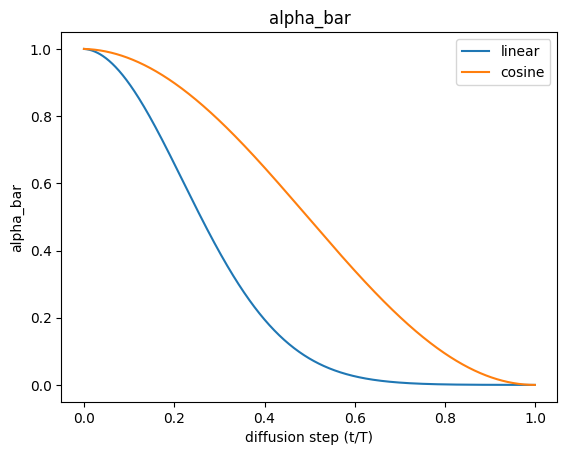

In [39]:
linear_alphas = compute_alpha(linear_beta_schedule(MAX_TIMESTEPS))
cosine_alphas = compute_alpha(cosine_beta_schedule(MAX_TIMESTEPS))
linear_alpha_bars = compute_alpha_bar(linear_alphas)
cosine_alpha_bars = compute_alpha_bar(cosine_alphas)

plt.title("alpha_bar")
plt.xlabel("diffusion step (t/T)")
plt.ylabel("alpha_bar")
plt.plot(np.arange(len(linear_alpha_bars)) / len(linear_alpha_bars), linear_alpha_bars, label="linear")
plt.plot(np.arange(len(cosine_alpha_bars)) / len(cosine_alpha_bars), cosine_alpha_bars, label="cosine")
plt.legend()
plt.show()

Select which scheduler to use. To prevent broadcasting images, reshape all three lists to (T, 1, 1, 1). Put the tensors on the device, and if you used NumPy to create the tensors, convert from double to floats.

In [40]:
scheduler = cosine_beta_schedule
# Compute the three tenors
beta = scheduler(MAX_TIMESTEPS)
alpha = compute_alpha(beta)
alpha_bar = compute_alpha_bar(alpha)
# Change shape and cast to tenors
beta = beta.reshape(-1, 1, 1, 1).to(device)
alpha = alpha.reshape(-1, 1, 1, 1).to(device)
alpha_bar = alpha_bar.reshape(-1, 1, 1, 1).to(device)

# Part 2: Implement the forward diffusion (training) process

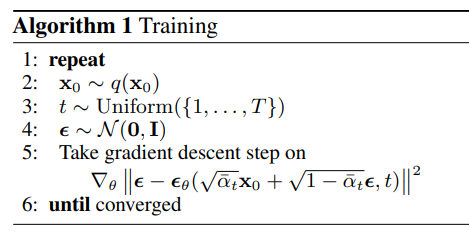

While you might be accustomed to pseudocode, deep learning pseudocode can sometimes be difficult to parse in the beginning and so we will explain all the steps here. The first thing to note is that **there is an implicit batch dimension included in the pseudocode**, so do not interpret this training loop as operating on a single image.

Line 2: Sample a batch of images $x_0$ from you dataset of images $q$. The subscript $0$ denotes the current timestep $t$, i.e. $x_{t=0} \equiv x_0$.

Line 3: Sample from the uniform distribution a batch of timesteps between 1 and $T$. The timesteps in the batch do not need to match.

Line 4: Sample noise from the normal distribution. In line 5 we see that the noise is going to be subtracted and multiplied element-wise to our batch of images. This means that the shape of the noise needs to match the shape of the batch of images, i.e. noise.shape = images.shape = (B, C, H, W).

Line 5: There is an implicit $x_t$ being created here where $x_t = \sqrt{\bar{\alpha}_t} x_0 + \sqrt{1 - \bar{\alpha}_t} \epsilon$. Therefore, $x_t$ and $t$ are passed into our diffusion model $\epsilon_{\theta}$. The model's goal is to predict the noise $\epsilon$ that was added into the model. $\lVert \epsilon - \epsilon_{\theta}(x_t, t) \rVert^2$ is our loss and it means to take the mean squared error between $\epsilon$ and our model's prediction of $\epsilon$. The final two parts of line 5 are $\nabla_{\theta}$ and "take the gradient descent step" which translates into pytorch as call `loss.backward()` and `optimizer.step()` respectively.

Lines 1 and 6 mean to continually train your model until there is no improvement.

In [61]:
def training(model, optimizer, dataloader, n_minibatches=1500):
    model.train()  # Let's the model know it is in training mode

    T = MAX_TIMESTEPS
    best_loss = float('inf')  # Store the best loss observed
    epochs_without_improvement = 0  # Counter for early stopping
    losses = []

    # Implement Algorithm 1 below. You can find what each symbol means in "Denoising Diffusion Probabilistic Models"
    # 1000-2000 minibatches (i.e. optimization steps) is sufficient for learning how to generate images, but more will help make better images
    for i, (images, _) in enumerate(dataloader):
        if i > n_minibatches: break
        x = images.to(device)  #(2)
        batch_size = x.shape[0]
        t = torch.randint(1, T + 1, (batch_size,)).to(device) # (3)
        noise = torch.randn_like(x).to(device)   # (4) Sample noise from normal distribution

        # Step (5): Gradient descent
        x_t = torch.sqrt(alpha_bar[t])*x + torch.sqrt(1-alpha_bar[t])*noise
        loss = nn.functional.mse_loss(noise, model(x_t, t))
        # loss = torch.norm(noise - model(x_t, t), dim=-1).pow(2).mean()
        losses.append(loss.item())

        if loss < best_loss:  # Early Stopping Check
            best_loss = loss  # Update best loss
            epochs_without_improvement = 0  # Reset counter
        else:
          epochs_without_improvement += 1  # Increment counter if no improvement
          if epochs_without_improvement >= 200: # Stop early if there is no improvement
              print(f"Minibatch {i} Loss: {loss.item()}")
              print(f"Stopping early at minibatch {i}, no improvement in the last 10 iterations.")
              break

        if i % 50 == 0 or i == n_minibatches:
            print(f"Minibatch {i} Loss: {loss.item()}")

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    return losses

# Part 3: Implement the backward diffusion (sampling) process

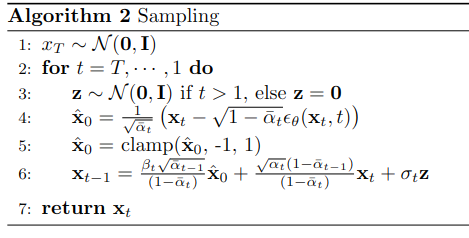

where $\bar{\alpha}_0 = 1$ and $\sigma_t = \sqrt{\beta_t}$.

**Note:** the only time $\alpha_t$ (without bar) is used instead of $\bar{\alpha}_t$ (with bar) is under the square root in the second term on line 6 (the numerator multiplied by $x_t$). If you mix up $\alpha$ and $\bar{\alpha}$, your sampling will not work!

In [56]:
@torch.no_grad()
def sampling(model, batch_size):
    model.eval()  # Let's the model know it is in validation mode
    T = MAX_TIMESTEPS

    # Implement Algorithm 2 below. You can find what each symbol means in "Denoising Diffusion Probabilistic Models"
    xt = torch.randn((batch_size, 1, image_size, image_size)).to(device) # (1)
    for t in range(T, 0, -1):
        z = torch.randn_like(xt).to(device) if t > 1 else torch.zeros_like(xt) # (3)
        t = torch.full((batch_size,), t).to(device)
        # t = torch.tensor([t]).to(device)
        x0 = (1 / torch.sqrt(alpha_bar[t])) * (xt - torch.sqrt(1 - alpha_bar[t]) * model(xt, t)) # (4)
        x0 = torch.clamp(x0, -1, 1) # (5)
        # Part (6)
        left = (beta[t] * torch.sqrt(alpha_bar[t - 1])) / (1 - alpha_bar[t])
        right = (torch.sqrt(alpha[t]) * (1 - alpha_bar[t - 1])) / (1 - alpha_bar[t])
        omega_t = torch.sqrt(beta[t])
        xt = left*x0 + right*xt + omega_t*z

    return xt  # return generated image

# Part 4: Train and generate images

In [11]:
preprocess_transform = Compose([
    Resize(image_size),
    ToTensor(),
    Lambda(lambda t: (t * 2) - 1),
])

In [62]:
model = UNetModel(
        in_channels=1,
        hidden_channels=32,
        out_channels=1,
        num_res_blocks=2,
        dropout=0.,
        channel_mult=(1, 2, 2, 2),
    ).to(device)

batch_size = 24
dataset = torchvision.datasets.MNIST("data/", train=True, download=True, transform=preprocess_transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

optimizer = AdamW(model.parameters(), lr=lr)

In [63]:
train_losses = training(model, optimizer, dataloader)

Minibatch 0 Loss: 0.9857149124145508
Minibatch 50 Loss: 0.614084780216217
Minibatch 100 Loss: 0.28333258628845215
Minibatch 150 Loss: 0.142166867852211
Minibatch 200 Loss: 0.07162035256624222
Minibatch 250 Loss: 0.046334680169820786
Minibatch 300 Loss: 0.053610365837812424
Minibatch 350 Loss: 0.04880310222506523
Minibatch 400 Loss: 0.05881286785006523
Minibatch 450 Loss: 0.05829095095396042
Minibatch 500 Loss: 0.03404312953352928
Minibatch 550 Loss: 0.06371146440505981
Minibatch 600 Loss: 0.02909858152270317
Minibatch 650 Loss: 0.04557549208402634
Minibatch 700 Loss: 0.03960501402616501
Minibatch 750 Loss: 0.053616296499967575
Minibatch 800 Loss: 0.040654052048921585
Minibatch 850 Loss: 0.045144133269786835
Minibatch 900 Loss: 0.023672837764024734
Minibatch 950 Loss: 0.03801023215055466
Minibatch 1000 Loss: 0.047250181436538696
Minibatch 1017 Loss: 0.03716559335589409
Stopping early at minibatch 1017, no improvement in the last 10 iterations.


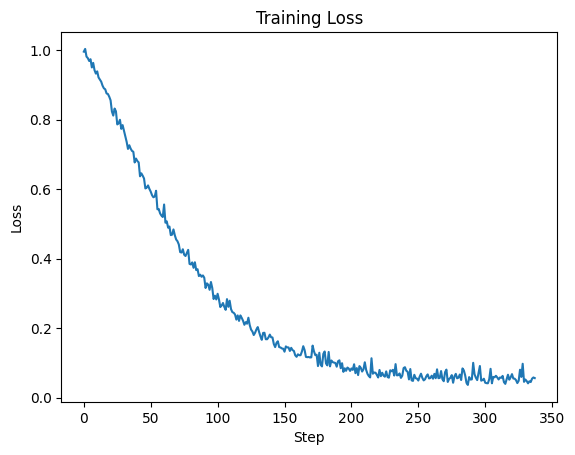

In [59]:
# plot your training loss
plt.title("Training Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.plot(train_losses)
plt.show()


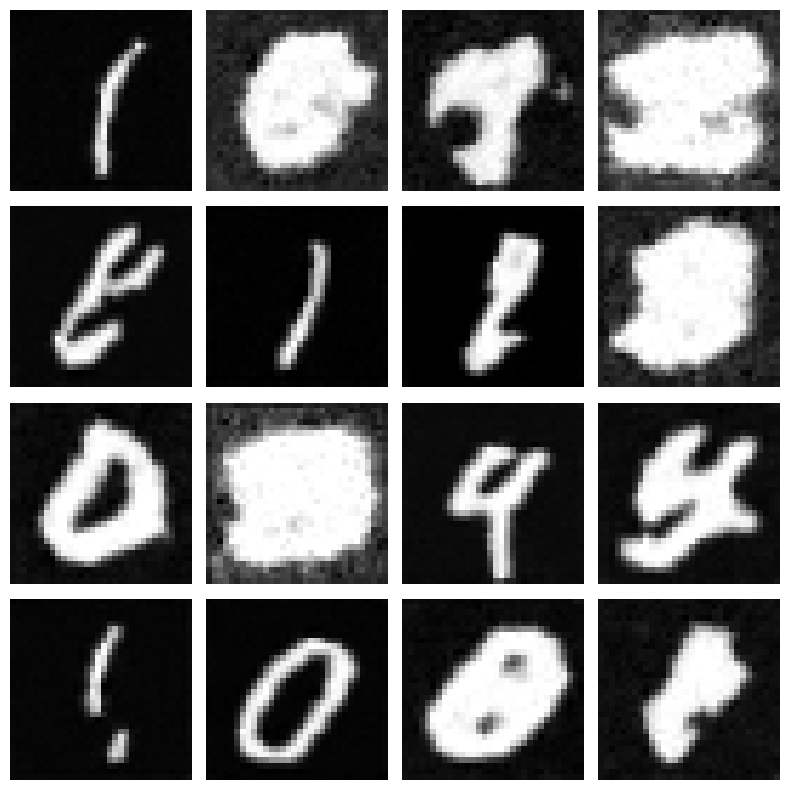

In [64]:
# Use sampling() to generate 16 images and plot them below
images = sampling(model, 16)

# Set up the plot grid: 4x4 grid for 16 images
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
axes = axes.flatten()

for i in range(16):   # Loop through each image and plot it
    ax = axes[i]
    image_np = images[i].cpu().squeeze().numpy()  # Conver to correct type
    ax.imshow(image_np, cmap='gray')
    ax.axis('off')  # Hide the axis

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


# Part 5: Questions

1. Where do we scale the values of our training data? What range do we scale the data to? Why do we scale the data in that range?

2. Why is the cosine scheduler better than the linear scheduler?

3. In the forward step, we perform a random number of denoising steps in one forward pass, but in the backward process, we have to perform T forward passes to generate images. Why is that?

4. What is our network learning to predict?

5. If we wanted to perform conditional generation; for example, if we wanted to provide our network with a digit and have it produce an image of that digit, what would we have to change?

1. We scale the values of our training data in pre-processing. This is done in the code provided before. It is normalized between -1 and 1 (where 0s go to -1 and 1 stays at 1). We do this because it cetners the data around 0, so that it can better match with the normal distribution.

2. As explained in the "Improved Denoising Diffusion Probabilistic Models" paper, the linear noise schedule does not work well for images of lower resolutions. This is because the end of the forward noising process is too noisy. This makes it not contribute much to the sample quality. The cosine learning schedule solves this problem by making the loss of information more linear in alpha bar (see the graphs in part 1). So, less information is lost, making the overall model better.

3. We perform a random number of denoising steps in the forward pass, but a fixed number in the backward pass becasue the dataloader already accounts for the information of the random number of steps (as it is defined earlier). So, it is only necessary to iterate through each time step. Afterall, we are only trying to match the noise at each step.

4. Our network learning is trying to predict the noise of each image. This means that it wants to be able to differentiate between the randomness of each image (rather the the inherent qualities). This in theory can allow us to understand better how the data is created, and synthesize it.

5. If we want to perform conditional generation, we would have to add a feature vector to the class label for each image. This can be passed into to the model, along with the noise, to encourage it to differentiate between classes and make the digits we specify.